In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [3]:
import torch
import torch.nn as nn

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size + n_categories, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size + n_categories, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, category):
        input_combined = torch.cat((input, hidden, category), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [20]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자부터 마지막(EOS) 까지의 long tensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [74]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [41]:
category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
print(category_tensor, input_line_tensor, target_line_tensor, sep='\n')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [169]:
model = RNN(n_letters, 1024, n_letters)
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0005)

In [170]:
def train(category_tensor, input_line_tensor, target_line_tensor, optimizer):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()
    model.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = model(input_line_tensor[i], hidden, category_tensor)
        l = loss_fn(output, target_line_tensor[i])
        loss += l

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return output, loss.item()/input_line_tensor.size(0)

In [171]:
n_iters = 500000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

for iter in range(1, n_iters+1):
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, input_line_tensor, target_line_tensor, optimizer)
    total_loss += loss

    if iter % print_every == 0:
        print(f'[{iter}/{n_iters}] loss : {loss}')

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

        
    

[5000/500000] loss : 3.0110450744628907
[10000/500000] loss : 3.497770071029663
[15000/500000] loss : 2.3703179359436035
[20000/500000] loss : 2.860161100115095
[25000/500000] loss : 2.119426727294922
[30000/500000] loss : 2.111856460571289
[35000/500000] loss : 1.6547704696655274
[40000/500000] loss : 2.7253101893833707
[45000/500000] loss : 2.5053932666778564
[50000/500000] loss : 1.7647114859686956
[55000/500000] loss : 3.3971872329711914
[60000/500000] loss : 2.2950946262904575
[65000/500000] loss : 2.6689023971557617
[70000/500000] loss : 2.81735576282848
[75000/500000] loss : 1.7611375808715821
[80000/500000] loss : 2.451295852661133
[85000/500000] loss : 2.5680383954729353
[90000/500000] loss : 2.081072235107422
[95000/500000] loss : 2.3528712136404857
[100000/500000] loss : 1.8964112599690754
[105000/500000] loss : 2.2941335678100585
[110000/500000] loss : 1.7945510864257812
[115000/500000] loss : 2.5342965807233537
[120000/500000] loss : 3.6075838529146633
[125000/500000] loss

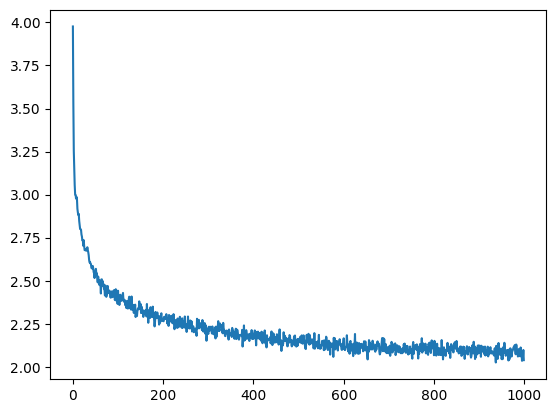

In [172]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [104]:
input = inputTensor('A')

In [109]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [164]:
category_lines['English']

['Abbas',
 'Abbey',
 'Abbott',
 'Abdi',
 'Abel',
 'Abraham',
 'Abrahams',
 'Abrams',
 'Ackary',
 'Ackroyd',
 'Acton',
 'Adair',
 'Adam',
 'Adams',
 'Adamson',
 'Adanet',
 'Addams',
 'Adderley',
 'Addinall',
 'Addis',
 'Addison',
 'Addley',
 'Aderson',
 'Adey',
 'Adkins',
 'Adlam',
 'Adler',
 'Adrol',
 'Adsett',
 'Agar',
 'Ahern',
 'Aherne',
 'Ahmad',
 'Ahmed',
 'Aikman',
 'Ainley',
 'Ainsworth',
 'Aird',
 'Airey',
 'Aitchison',
 'Aitken',
 'Akhtar',
 'Akram',
 'Alam',
 'Alanson',
 'Alber',
 'Albert',
 'Albrighton',
 'Albutt',
 'Alcock',
 'Alden',
 'Alder',
 'Aldersley',
 'Alderson',
 'Aldred',
 'Aldren',
 'Aldridge',
 'Aldworth',
 'Alesbury',
 'Alexandar',
 'Alexander',
 'Alexnader',
 'Alford',
 'Algar',
 'Ali',
 'Alker',
 'Alladee',
 'Allam',
 'Allan',
 'Allard',
 'Allaway',
 'Allcock',
 'Allcott',
 'Alldridge',
 'Alldritt',
 'Allen',
 'Allgood',
 'Allington',
 'Alliott',
 'Allison',
 'Allkins',
 'Allman',
 'Allport',
 'Allsop',
 'Allum',
 'Allwood',
 'Almond',
 'Alpin',
 'Alsop',
 'A

In [180]:
start_letter = 'A'
category = 'English'
with torch.no_grad():
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = model.initHidden()

    output_name = start_letter

    for i in range(30):
        output, hidden = model(input[0], hidden, category_tensor)
        # if i==0:
        #     letter = 'l'
        #     output_name += letter
        #     input = inputTensor(letter)
        #     continue
        topv, topi = output.topk(1)
        if topi == n_letters -1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = inputTensor(letter)
    print(category)
    print(output_name)
        

English
Aller
